In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# SHAP: Random hierarchy
Shapley comparisons for random group hierarchy models. 

*This script takes about 10 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, importlib

In [3]:
from pathlib import Path

In [4]:
import shap
import xgboost as xgb

## Data

In [5]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [6]:
train_df = sba_loans[sba_loans['dset'] == 'train']

## Models 
Load a bunch of models and create a dictionary.  Also get model-related data into dictionaries.

In [7]:
# Function to load the required information from models
def model_load(prefix = 'X01', path=setup.temp_path):
    model = xgb.Booster()
    model.load_model(Path(path).joinpath(prefix + '_MODEL_xgboost.json'))
    with open(Path(path).joinpath(prefix + '_DATA_features_predict.pkl'), 'rb') as fin:
        features_predict = pickle.load(fin)
    features_values = pd.read_parquet(Path(path).joinpath(prefix + '_DATA_encodings.parquet'))
    features_columns = [c for c in features_values.columns \
                        if c not in ['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']]

        
    return model, features_values, features_columns, features_predict

##### Models

In [8]:
# Standard target encoding 
xgb_model_menc, features_menc_values, features_menc_columns, features_predict_menc = \
    model_load('X04', setup.parent_path)

In [9]:
# Hierarchical target encoding
xgb_model_mhier, features_mhier_values, features_mhier_columns, features_predict_mhier = \
    model_load('A42', setup.temp_path)

In [10]:
# Standard target encoding of all levels (separately)
xgb_model_menc_all, features_menc_all_values, features_menc_all_columns, features_predict_menc_all = \
    model_load('A45', setup.temp_path)

In [11]:
# Target+Count encoding, all levels 
xgb_model_tc, features_tc_values, features_tc_columns, features_predict_tc = \
    model_load('A43', setup.temp_path)

In [12]:
# Target-Thresh encoding, all levels 
xgb_model_tt, features_tt_values, features_tt_columns, features_predict_tt = \
    model_load('A44', setup.temp_path)

In [13]:
# Encoding column(s) into dictionary
feature_dict = {'menc': features_menc_columns, 
                'mhier':features_mhier_columns,
                'menc_all': features_menc_all_columns,
                'tc':features_tc_columns,
                 'tt':features_tt_columns}

In [14]:
# Encoded values into dictionary
feature_values_dict = {'menc': features_menc_values,
                       'mhier':features_mhier_values,
                       'menc_all': features_menc_all_values,
                       'tc':features_tc_values,
                       'tt':features_tt_values}

In [15]:
{feature_values_dict[k].shape for k in feature_values_dict.keys()}

{(688081, 5), (688081, 8), (688081, 9), (688081, 14)}

In [16]:
# Order for plots and tables, also print labels
feature_order = ['menc', 'mhier', 'menc_all', 'tc', 'tt']
num_models = len(feature_order)
print_dict = {'menc': 'Target encoding (NAICS only)', 
                'mhier':'Hierarchical Blending',
                'menc_all': 'Target encoding (NAICS hierarchy)',
                'tc':'Target+Count encoding',
                 'tt':'Target-Thresh encoding'}

In [17]:
# Models into a dictionary
model_dict = {'menc': xgb_model_menc, 
                'mhier':xgb_model_mhier,
                'menc_all': xgb_model_menc_all,
                'tc':xgb_model_tc,
                 'tt':xgb_model_tt}

In [18]:
# Predictor dictionary for compactness
predictor_dict = {'menc': features_predict_menc, 
                 'mhier':features_predict_mhier,
                'menc_all': features_predict_menc_all,
                'tc':features_predict_tc,
                 'tt':features_predict_tt}

In [19]:
predictor_dict.keys()

dict_keys(['menc', 'mhier', 'menc_all', 'tc', 'tt'])

## Datasets for Explanations
Wamt to use the same cases for all models.  Use the test holdout, and regular test data.  I need to append different features for each

In [20]:
# Function to get a dataset for a given modeal
def model_data(base_data, features_data, predictors_list):
    
    drop_cols = [c for c in features_data.columns if c != 'LoanNr_ChkDgt']
    data = base_data \
        .drop(columns = drop_cols, errors='ignore') \
        .merge(features_data,
               how='inner', on='LoanNr_ChkDgt')
    return data

##### Holdout data
Create data frames for all models

In [21]:
holdout_base = sba_loans[sba_loans['dset_naics_holdout'] == 1]

In [22]:
model_data_holdout_dict = {k: model_data(holdout_base, feature_values_dict[k],
                                 predictor_dict[k]) for k in feature_values_dict.keys()}

In [23]:
# Print the data shapes
{k:model_data_holdout_dict[k].shape for k in feature_values_dict.keys()}

{'menc': (65052, 58),
 'mhier': (65052, 59),
 'menc_all': (65052, 62),
 'tc': (65052, 68),
 'tt': (65052, 63)}

##### Random test data
Downsample a bit for speed.  Use the same data for all

In [24]:
sample_n = np.min([len(sba_loans['dset_naics_holdout'] == 0), 50000])
test_base = sba_loans[sba_loans['dset_naics_holdout'] == 0] \
    .sample(n=sample_n, random_state = 6)

In [25]:
model_data_test_dict = {k: model_data(test_base, feature_values_dict[k],
                                 predictor_dict[k]) for k in feature_values_dict.keys()}

In [26]:
# Print the data shapes
{k:model_data_test_dict[k].shape for k in feature_values_dict.keys()}

{'menc': (50000, 58),
 'mhier': (50000, 59),
 'menc_all': (50000, 62),
 'tc': (50000, 68),
 'tt': (50000, 63)}

## SHAP Explainers, Values
For the 3 models, generate explainers then explanations

##### Explainers

In [27]:
explainer_dict = {k: \
                  shap.TreeExplainer(model_dict[k], feature_names=predictor_dict[k]) \
              for k in predictor_dict.keys()}

In [28]:
explainer_dict

{'menc': <shap.explainers._tree.TreeExplainer at 0x2eee7fcd0>,
 'mhier': <shap.explainers._tree.TreeExplainer at 0x2eee7f820>,
 'menc_all': <shap.explainers._tree.TreeExplainer at 0x2eee7f940>,
 'tc': <shap.explainers._tree.TreeExplainer at 0x2eee7f400>,
 'tt': <shap.explainers._tree.TreeExplainer at 0x2eee7f5e0>}

##### Holdout values

In [29]:
shap_holdout_dict = {k: 
                     explainer_dict[k].shap_values(model_data_holdout_dict[k][predictor_dict[k]])
                     for k in predictor_dict.keys()}

##### Random test values

In [30]:
shap_test_dict = {k: 
                     explainer_dict[k].shap_values(model_data_test_dict[k][predictor_dict[k]])
                     for k in predictor_dict.keys()}

##### Save data

In [31]:
with open(Path(setup.temp_path).joinpath('A46_DATA_raw_shap_dict_ho.pkl'), 'wb') as fout:
    pickle.dump(shap_holdout_dict, fout)

In [32]:
with open(Path(setup.temp_path).joinpath('A46_DATA_raw_shap_dict_test.pkl'), 'wb') as fout:
    pickle.dump(shap_test_dict, fout)

##### Data frame convert and save

In [33]:
shap_holdout_df_dict = {k: pd.DataFrame(shap_holdout_dict[k], columns=predictor_dict[k],
                                       index = model_data_holdout_dict[k].index)
                        for k in predictor_dict.keys()}
with open(Path(setup.temp_path).joinpath('A46_DATA_df_shap_dict_ho.pkl'), 'wb') as fout:
    pickle.dump(shap_holdout_df_dict, fout)

In [34]:
shap_test_df_dict = {k: pd.DataFrame(shap_test_dict[k], columns=predictor_dict[k],
                                    index = model_data_test_dict[k].index)
                        for k in predictor_dict.keys()}
with open(Path(setup.temp_path).joinpath('A46_DATA_df_shap_dict_test.pkl'), 'wb') as fout:
    pickle.dump(shap_test_df_dict, fout)

## Long Format Data

In [35]:
# Function to convert SHAP data to a frame in long format
def get_shap_long(shap_df, features_encoded):
    
    long_df = shap_df.melt(ignore_index = False)
    
    long_df['enc_flag'] = np.where(long_df['variable'].isin(features_encoded), 1, 0)
    
    return long_df

In [36]:
# Apply the function to all models and concatenate
shap_all_long_test = pd.concat([get_shap_long(shap_test_df_dict[k],feature_dict[k]) \
                              .reset_index()
                         for k in predictor_dict.keys()],
                        keys=predictor_dict.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'}) \
    .reset_index(drop=True)

In [37]:
shap_all_long_test.to_parquet(Path(setup.temp_path).joinpath('A46_DATA_shap_long_test.parquet'))

In [38]:
# Apply the function to all models and concatenate
shap_all_long_ho = pd.concat([get_shap_long(shap_holdout_df_dict[k],feature_dict[k]) \
                              .reset_index()
                         for k in predictor_dict.keys()],
                        keys=predictor_dict.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'}) \
    .reset_index(drop=True)

In [39]:
shap_all_long_ho.to_parquet(Path(setup.temp_path).joinpath('A46_DATA_shap_long_ho.parquet'))

## Encoding vs. Non-Encoding Features

In [40]:
def aggregate_by_enc_flag(data):
    data_1 = data \
        .groupby(['model', 'enc_flag', 'index']) \
        ['value'] \
        .agg('sum') \
        .reset_index(level=[0,1])
    data_1['value_abs'] = np.abs(data_1['value'])
    data_2 = data_1 \
        .groupby(['model', 'enc_flag']) \
        [['value_abs', 'value']] \
        .agg('mean') \
        .reset_index()
    return data_2

In [41]:
enc_flag_agg_test = aggregate_by_enc_flag(shap_all_long_test)
enc_flag_agg_test

,model,enc_flag,value_abs,value
0,menc,0,0.554551,-0.143952
1,menc,1,0.366625,-0.059871
2,menc_all,0,0.554773,-0.145215
3,menc_all,1,0.364775,-0.058457
4,mhier,0,0.555447,-0.143826
5,mhier,1,0.364048,-0.059275
6,tc,0,0.551243,-0.143915
7,tc,1,0.365725,-0.058803
8,tt,0,0.562903,-0.145352
9,tt,1,0.342811,-0.057289


In [42]:
enc_flag_agg_ho = aggregate_by_enc_flag(shap_all_long_ho)
enc_flag_agg_ho

,model,enc_flag,value_abs,value
0,menc,0,0.648219,-0.259119
1,menc,1,0.093835,0.093832
2,menc_all,0,0.641592,-0.256922
3,menc_all,1,0.100106,0.099848
4,mhier,0,0.646002,-0.231693
5,mhier,1,0.332353,-0.089548
6,tc,0,0.670502,-0.270190
7,tc,1,0.077986,0.075612
8,tt,0,0.705724,-0.213267
9,tt,1,0.166337,-0.164397


##### Plot

In [43]:
# Function to do bar plot
def shap_enc_flag_bar(data, values = 'value_abs',
                      title = None, xlabel = None, ax = None):
    
    # Label models
    data['model_label']  = setup.label_models(data)

    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
    data_pivot = data.pivot(index='model_label', columns='enc_flag', values=values) \
        .rename(columns={0:'other features', 1:'NAICS encoding feature(s)'})
    data_pivot .plot(kind='barh', ax=ax, width=0.7)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    #ax.legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)

In [44]:
setup.label_models(enc_flag_agg_test)

0    Target Encoding (NAICS only)
1    Target Encoding (NAICS only)
2           Target Encoding (all)
3           Target Encoding (all)
4           Hierarchical Blending
5           Hierarchical Blending
6           Target+Count Encoding
7           Target+Count Encoding
8          Target-Thresh Encoding
9          Target-Thresh Encoding
Name: model, dtype: category
Categories (5, object): ['Target Encoding (NAICS only)' < 'Hierarchical Blending' < 'Target Encoding (all)' < 'Target+Count Encoding' < 'Target-Thresh Encoding']

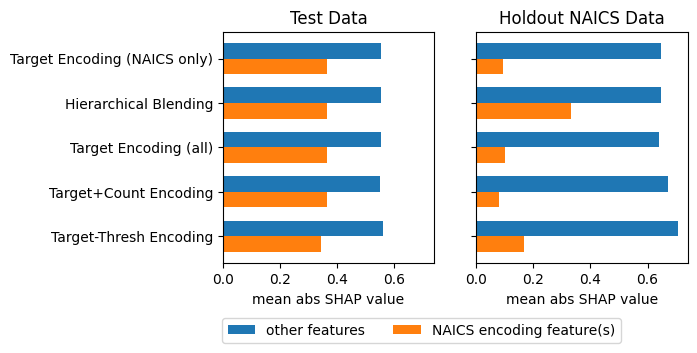

In [45]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(6, 3))
shap_enc_flag_bar(enc_flag_agg_test, ax=ax[0], title='Test Data',
                     xlabel='mean abs SHAP value')
shap_enc_flag_bar(enc_flag_agg_ho, ax=ax[1], title='Holdout NAICS Data',
                     xlabel='mean abs SHAP value')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)
fig.savefig(Path(setup.temp_path).joinpath('A46_PLOT_enc_flag_mean_abs.png'),
        bbox_inches='tight')

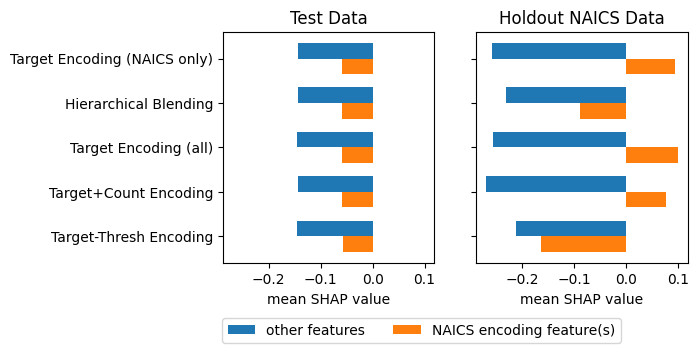

In [46]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(6, 3))
shap_enc_flag_bar(enc_flag_agg_test, 'value', ax=ax[0], title='Test Data',
                     xlabel='mean SHAP value')
shap_enc_flag_bar(enc_flag_agg_ho, 'value', ax=ax[1], title='Holdout NAICS Data',
                     xlabel='mean SHAP value')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)
fig.savefig(Path(setup.temp_path).joinpath('A46_PLOT_enc_flag_mean_raw.png'),
        bbox_inches='tight')

In [47]:
enc_flag_agg_test.to_csv(Path(setup.temp_path).joinpath('A46_REPORT_importance_enc_flag_test.csv'))
enc_flag_agg_ho.to_csv(Path(setup.temp_path).joinpath('A46_REPORT_importance_enc_flag_ho.csv'))

## Detail Importances

##### Get mean abs shap, grouping non-encoding features into "other"
We only need this for the models with more than one encoding feature

In [51]:
def get_importances(long_df):
    agg_1 = long_df[long_df['enc_flag'] == 0] \
        .groupby(['model', 'index']) \
        ['value'] \
        .agg('sum') \
        .reset_index()
    agg_1['variable'] = 'other'
    agg_2 = pd.concat([agg_1,long_df[long_df['enc_flag'] == 1]])
    agg_2['value_abs'] = np.abs(agg_2['value'])
    
    imp_df = agg_2.groupby(['model', 'variable']) \
        ['value_abs'] \
        .agg('mean') \
        .reset_index()
    imp_df['model_label']  = setup.label_models(imp_df)
    return imp_df

In [52]:
import_all_test = get_importances(shap_all_long_test)
import_all_test.to_csv(Path(setup.temp_path).joinpath('A46_REPORT_importance_detail_test.csv'))

In [53]:
import_all_ho = get_importances(shap_all_long_ho)
import_all_ho.to_csv(Path(setup.temp_path).joinpath('A46_REPORT_importance_detail_ho.csv'))

In [54]:
shap_all_long_ho['enc_flag'].isna().value_counts()

enc_flag
False    3707964
Name: count, dtype: int64

##### Plot

In [55]:
# Some data processing for bar plots
def shap_import_bar_preprocess(data, values = 'value_abs', n_bars=7):
    data= data.sort_values(values, ascending=False).head(n_bars).copy() \
        [['model', 'variable', values]]
    
    data['model_label']  = setup.label_models(data)
    data['model_label'] = data['model_label'].astype('str')
    
    # Rename features
    if data['model'].iloc[0] in ['tt', 'menc_all']:
        data['variable'] = data['variable'].where(~data['variable'].str.contains('NAICS'),
                                              'NAICS' + data['variable'].str.split('NAICS').str[-1])
    elif data['model'].iloc[0] == 'tc':
                data['variable'] = data['variable'].where(~data['variable'].str.endswith('_response'),
                                              data['variable'].str.replace('_response', ''))
    return data

In [56]:
# Function to do bar plot for one model
def shap_import_bar(data, values = 'value_abs',
                      xlabel = None, ax = None,
                   n_bars=7):

    # Feature selection, renaming
    data = shap_import_bar_preprocess(data, values, n_bars)
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
        
    data.plot(x='variable', y=values, ax=ax, kind='barh', legend=None)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(data['model_label'].iloc[0])
    ax.set_xlabel(xlabel)
    #ax.legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)

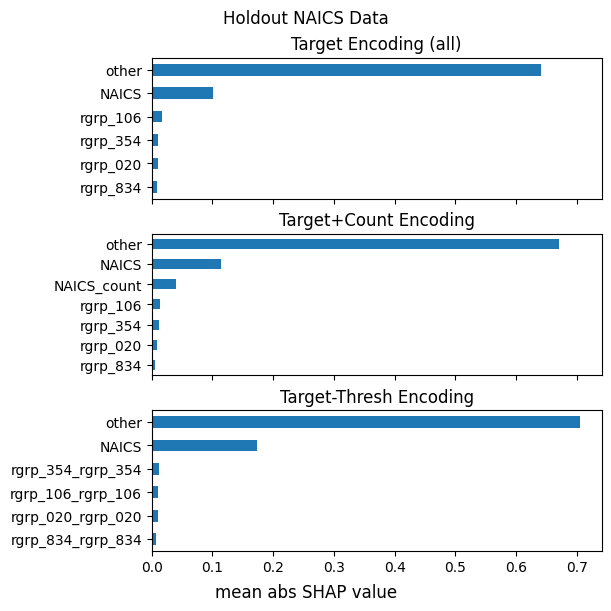

In [57]:
fig, ax = plt.subplots(3, 1, sharex = True, sharey = False, figsize=(6, 6),
                      layout='constrained')
shap_import_bar(import_all_ho[import_all_ho['model'] == 'menc_all'], ax=ax[0])
shap_import_bar(import_all_ho[import_all_ho['model'] == 'tc'], ax=ax[1])
shap_import_bar(import_all_ho[import_all_ho['model'] == 'tt'], ax=ax[2])
fig.suptitle('Holdout NAICS Data')
fig.supxlabel('mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('A46_PLOT_importancs_holdout.png'))

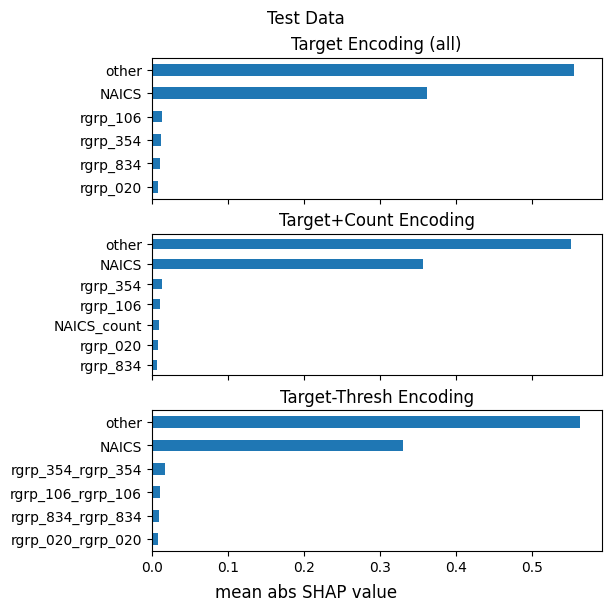

In [58]:
fig, ax = plt.subplots(3, 1, sharex = True, sharey = False, figsize=(6, 6),
                      layout='constrained')
shap_import_bar(import_all_test[import_all_test['model'] == 'menc_all'], ax=ax[0])
shap_import_bar(import_all_test[import_all_test['model'] == 'tc'], ax=ax[1])
shap_import_bar(import_all_test[import_all_test['model'] == 'tt'], ax=ax[2])
fig.suptitle('Test Data')
fig.supxlabel('mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('A46_PLOT_importancs_test.png'))

#### Single, bi-color plot

In [59]:
# Function to do bar plot for one model
def shap_import_bar_2color(data_test, data_holdout, values = 'value_abs',
                      xlabel = None, ax = None,
                   n_bars=7):

    data_test = shap_import_bar_preprocess(data_test, values, n_bars)
    data_holdout = shap_import_bar_preprocess(data_holdout, values, n_bars)
    
    data = pd.concat([data_test, data_holdout], keys=['test', 'holdout']) \
        .reset_index(level=0)
    
    data_pivot = data.pivot(index=['variable'], columns=['level_0'],
                                      values = values) \
        .sort_values('test', ascending=False)
    
    data_pivot = data_pivot[['test', 'holdout']]
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
        
    data_pivot.plot(kind='barh', ax=ax, width=0.9)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(data['model_label'].iloc[0])
    ax.set_xlabel(xlabel)
    ax.legend(title=None)

Text(0.5, 0.01, 'mean abs SHAP value')

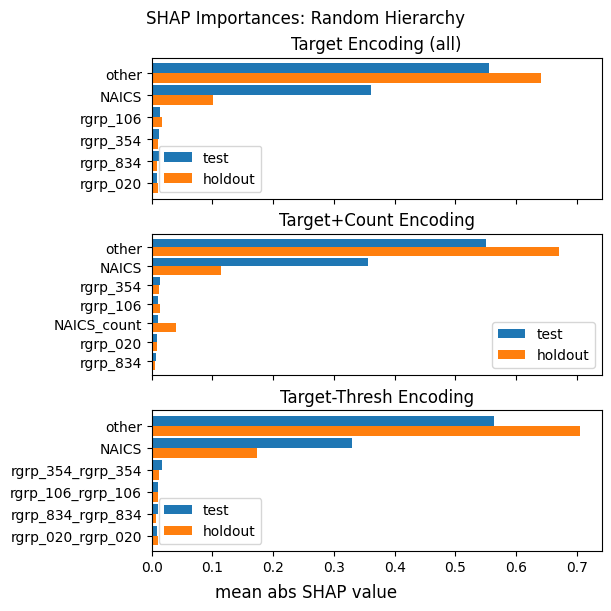

In [60]:
models = ['menc_all', 'tc', 'tt']
fig, ax = plt.subplots(3, 1, sharex = True, sharey = False, figsize=(6, 6),
                      layout='constrained')
for i, model in enumerate(models):
    shap_import_bar_2color(import_all_test[import_all_test['model'] == model],
                       import_all_ho[import_all_ho['model'] == model],
                          ax=ax[i])
fig.suptitle('SHAP Importances: Random Hierarchy')
fig.supxlabel('mean abs SHAP value')

## 3 Bar Plot
Show other features, main NAICS feature, and all other features as importance

In [82]:
cat_type= pd.CategoricalDtype(categories = ['Other Features', 'NAICS-Primary', 'NAICS-Hier/Other'],
                                 ordered=True)

In [83]:
def agg_enc_3way(data):
    data = data.copy()
    #cond = [data['enc_flag'] == 0,
    #        data['variable'].isin(['NAICS_NAICS', 'NAICS_response','mhier_NAICS_alt', 'menc_NAICS',
    #                              'NAICS', 'mhier_NAICS'])]
    #choice = ['Other Features', 'NAICS-Primary']
    cond = [data['enc_flag'] == 0, data['variable'].isin(['NAICS_NAICS', 'NAICS_response','mhier_NAICS_alt', 'menc_NAICS',
                                 'NAICS', 'mhier_NAICS'])]
    choice = ['Other Features', 'NAICS-Primary']
    data['type'] = pd.Series(np.select(cond, choice, 'NAICS-Hier/Other'))
    data_1 = data \
        .groupby(['model', 'type', 'index']) \
        ['value'] \
        .agg('sum') \
        .reset_index(level=[0,1])
    data_1['value_abs'] = np.abs(data_1['value'])
    data_2 = data_1 \
        .groupby(['model', 'type']) \
        [['value_abs', 'value']] \
        .agg('mean') \
        .reset_index()
    data_2['type'] = data_2['type'].astype(cat_type)
    return data_2

In [62]:
enc_way_test = agg_enc_3way(shap_all_long_test)
enc_way_test

,model,type,value_abs,value
0,menc,NAICS-Primary,0.366625,-0.059871
1,menc,Other Features,0.554551,-0.143952
2,menc_all,NAICS-Hier/Other,0.029411,0.005736
3,menc_all,NAICS-Primary,0.361128,-0.064193
4,menc_all,Other Features,0.554773,-0.145215
5,mhier,NAICS-Primary,0.364048,-0.059275
6,mhier,Other Features,0.555447,-0.143826
7,tc,NAICS-Hier/Other,0.031765,0.007488
8,tc,NAICS-Primary,0.356309,-0.066290
9,tc,Other Features,0.551243,-0.143915


In [63]:
enc_way_ho=  agg_enc_3way(shap_all_long_ho)
enc_way_ho

,model,type,value_abs,value
0,menc,NAICS-Primary,0.093835,0.093832
1,menc,Other Features,0.648219,-0.259119
2,menc_all,NAICS-Hier/Other,0.030536,-0.001329
3,menc_all,NAICS-Primary,0.101189,0.101178
4,menc_all,Other Features,0.641592,-0.256922
5,mhier,NAICS-Primary,0.332353,-0.089548
6,mhier,Other Features,0.646002,-0.231693
7,tc,NAICS-Hier/Other,0.053770,-0.038086
8,tc,NAICS-Primary,0.113698,0.113697
9,tc,Other Features,0.670502,-0.270190


In [73]:
enc_way_test.to_csv(Path(setup.temp_path).joinpath('A46_DATA_shap_three_grp_test.csv'))
enc_way_ho.to_csv(Path(setup.temp_path).joinpath('A46_DATA_shap_three_grp_ho.csv'))

In [64]:
shap_all_long_ho[['variable', 'enc_flag']].drop_duplicates()

,variable,enc_flag
0,NoEmp,0
65052,CreateJob,0
130104,LowDoc,0
195156,DisbursementGross,0
260208,new_business,0
325260,urban_flag,0
390312,franchise_flag,0
455364,menc_NAICS,1
975780,mhier_NAICS_alt,1
1496196,NAICS,1


In [102]:
# Function to do bar plot
def shap_3way_bar(data, values = 'value_abs',
                      title = None, xlabel = None, ax = None,
                 figsize = None, width=0.7):
    
    # Label models
    data = data.copy()
    data['model_label']  = setup.label_models(data)
    data['type'] = data['type'].astype(cat_type)

    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
    data_pivot = data.pivot(index='model_label', columns='type', values=values) \
        .reset_index()
    data_pivot['model_label'] = data_pivot['model_label'].astype(setup.model_label_type)
    data_pivot.sort_values('model_label').set_index('model_label') \
        .plot(kind='barh', ax=ax, width=width, figsize=figsize)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    #ax.legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)

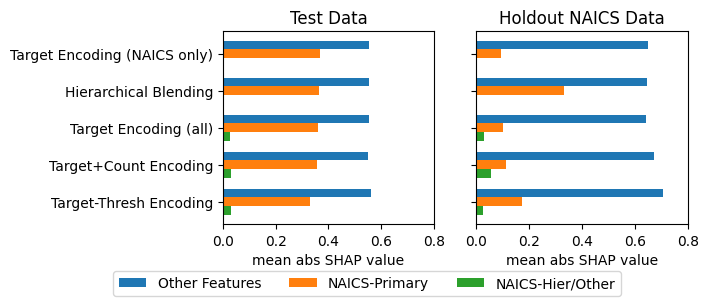

In [69]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(6, 2.5))
shap_3way_bar(enc_way_test, 'value_abs', ax=ax[0], title='Test Data',
                     xlabel='mean abs SHAP value')
shap_3way_bar(enc_way_ho, 'value_abs', ax=ax[1], title='Holdout NAICS Data',
                     xlabel='mean abs SHAP value')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=3)
ax[0].set_xlim(0, 0.8)
ax[1].set_xlim(0, 0.8)
fig.savefig(Path(setup.temp_path).joinpath('A46_PLOT_enc_type_3bar.png'),
        bbox_inches='tight')

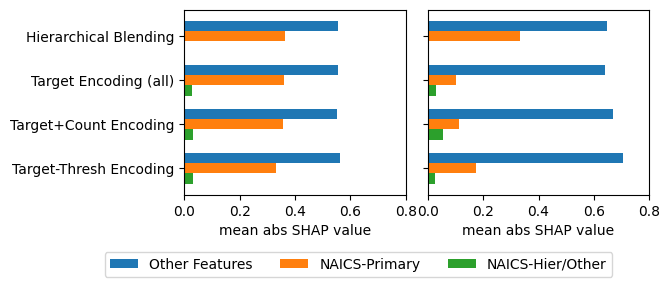

In [72]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True,
                      figsize=(6,2.4))

# All but target encoding
shap_3way_bar(enc_way_test[enc_way_test['model'] != 'menc'], 
              'value_abs', ax=ax[0],xlabel='mean abs SHAP value')
shap_3way_bar(enc_way_ho[enc_way_ho['model'] != 'menc'], 
              'value_abs', ax=ax[1],
                     xlabel='mean abs SHAP value')
[a.get_legend().remove() for a in ax ]
[a.set_xlim(0, 0.8) for a in ax ]
ax[1].legend(bbox_to_anchor=(0.85, -0.1),  bbox_transform=fig.transFigure, ncol=3)
fig.set_figwidth(6)
plt.subplots_adjust(hspace=0.01, wspace=0.1)
fig.savefig(Path(setup.temp_path).joinpath('A46_PLOT_3bar_condensed.png'),
        bbox_inches='tight')

#### Blog - make final all plot

In [76]:
enc_way_test_base = pd.read_csv(Path(setup.temp_path).joinpath('A40_DATA_shap_three_grp_test.csv'))
enc_way_ho_base = pd.read_csv(Path(setup.temp_path).joinpath('A40_DATA_shap_three_grp_ho.csv'))

In [77]:
enc_way_test_dgi = pd.read_csv(Path(setup.temp_path).joinpath('A41_DATA_shap_three_grp_test.csv'))
enc_way_ho_dgi = pd.read_csv(Path(setup.temp_path).joinpath('A41_DATA_shap_three_grp_ho.csv'))

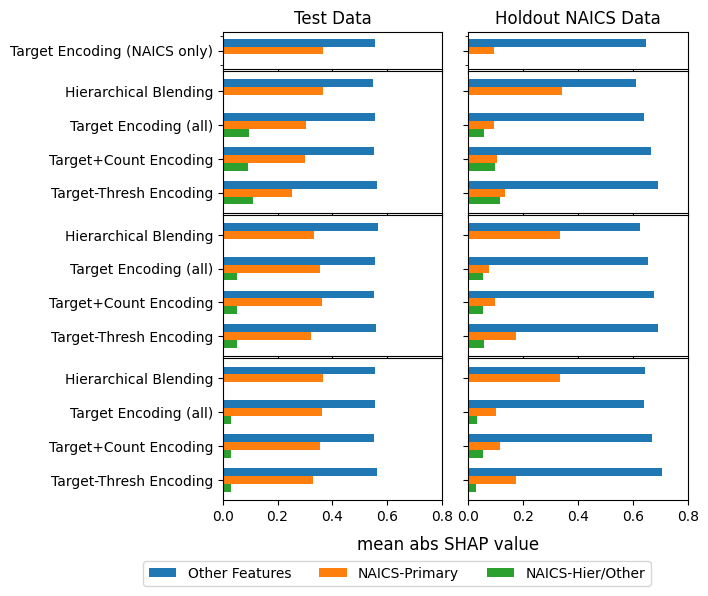

In [125]:
fig, ax = plt.subplots(4, 2, sharex = True, sharey = 'row',
                       gridspec_kw={'height_ratios': [1, 3.8, 3.8, 3.8]},
                      figsize=(6,6))

# Only target encoding
shap_3way_bar(enc_way_test_base[enc_way_test_base['model'] == 'menc'], 
              values='value_abs', ax=ax[0, 0], title='Test Data',
             width=0.8)
shap_3way_bar(enc_way_ho_base[enc_way_ho_base['model'] == 'menc'], 
              values='value_abs', ax=ax[0, 1],  title='Holdout NAICS Data', width=0.8)

# NAICS hierarchy
shap_3way_bar(enc_way_test_base[enc_way_test_base['model'] != 'menc'], 
              values='value_abs', ax=ax[1, 0])
shap_3way_bar(enc_way_ho_base[enc_way_ho_base['model'] != 'menc'], 
              values='value_abs', ax=ax[1, 1])

# DGI hierarchy
shap_3way_bar(enc_way_test_dgi[enc_way_test_dgi['model'] != 'menc'], 
              values='value_abs', ax=ax[2, 0])
shap_3way_bar(enc_way_ho_dgi[enc_way_ho_dgi['model'] != 'menc'], 
              values='value_abs', ax=ax[2, 1])

# Random hierarchy
shap_3way_bar(enc_way_test[enc_way_test['model'] != 'menc'], 
              values='value_abs', ax = ax[3, 0])
shap_3way_bar(enc_way_ho[enc_way_ho['model'] != 'menc'], 
              values='value_abs', ax = ax[3, 1])

[a.get_legend().remove() for al in ax for a in al]
[a.set_xlim(0, 0.8) for al in ax for a in al ]
fig.set_figwidth(6)
plt.subplots_adjust(hspace=0.015, wspace=0.12, bottom=0.1)
fig.supxlabel('mean abs SHAP value')
ax[3,1].legend(bbox_to_anchor=(0.85, 0.01),  bbox_transform=fig.transFigure, ncol=3)
#ax[0,1].legend(bbox_to_anchor=(1, 1.1))
fig.savefig(Path(setup.temp_path).joinpath('A46_PLOT_3bar_condensed_combined.png'),
        bbox_inches='tight')